In [1]:
#! pip install ctgan
# !pip install --upgrade category_encoders
# !pip install scikit-learn

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import xgboost as xgb
# Fairlearn - for disparity metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_positive_rate, true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.datasets import fetch_diabetes_hospital
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import StratifiedKFold, ParameterGrid
import json
import csv
import os



In [2]:
# =====================================================
# Synthetic Data Setup 
# =====================================================


data = fetch_diabetes_hospital()
X_raw = data.data   
Y = data.target     


df = X_raw.copy()
df["target"] = Y

# Downsampling
df_sampled, _ = train_test_split(
    df, 
    train_size=8000, 
    random_state=42, 
    stratify=df["race"]  # Ensuring class distribution is maintained
)
drop_candidates = ["readmitted", "readmit_binary", "target"] # Drop these columns since they are directly related to the target

# Separate features, labels, and sensitive attribute
Y_downsampled = df_sampled["target"]
A_downsampled = df_sampled["race"]          # Protected attribute
X_downsampled = df_sampled.drop(columns=drop_candidates)

# Check shapes
print("X_downsampled shape:", X_downsampled.shape)
print("Y_downsampled shape:", Y_downsampled.shape)
print("A_downsampled shape:", A_downsampled.shape)

X_downsampled shape: (8000, 22)
Y_downsampled shape: (8000,)
A_downsampled shape: (8000,)


In [3]:
cat_cols = X_downsampled.select_dtypes(include=["object", "category"]).columns

# Identify binary columns
binary_cols = [col for col in cat_cols if X_downsampled[col].nunique() == 2]

# Columns to encode (excluding binary columns)
non_binary_cols = [col for col in cat_cols if col not in binary_cols]

# Initialize the OneHotEncoder
enc = OneHotEncoder(sparse_output=False)

# Encode non-binary categorical columns
X_cat_array = enc.fit_transform(X_downsampled[non_binary_cols])

# Get encoded column names
encoded_col_names = enc.get_feature_names_out(non_binary_cols)

# Create a DataFrame with the encoded values and column names
encoded_df = pd.DataFrame(X_cat_array, columns=encoded_col_names, index=X_downsampled.index)

# Add the binary columns back to the encoded DataFrame
X_encoded = pd.concat([X_downsampled[binary_cols], encoded_df], axis=1)

print(X_encoded.head())
print(f"Shape before encoding: {X_downsampled.shape}")
print(f"Shape after encoding:  {X_encoded.shape}")

        gender discharge_disposition_id change diabetesMed medicare medicaid  \
659       Male                    Other     No         Yes    False    False   
100034    Male                    Other     Ch         Yes    False    False   
46129     Male                    Other     No         Yes     True    False   
53647   Female                    Other     No          No    False    False   
51185     Male                    Other     Ch         Yes    False    False   

       had_emergency had_inpatient_days had_outpatient_days  \
659            False              False               False   
100034         False              False               False   
46129          False              False               False   
53647          False              False               False   
51185           True              False                True   

        race_AfricanAmerican  ...  max_glu_serum_None  max_glu_serum_Norm  \
659                      0.0  ...                 1.0          

In [6]:
# Boolean columns (True/False)
bool_cols = X_encoded.select_dtypes(include=["bool"]).columns
X_encoded[bool_cols] = X_encoded[bool_cols].astype(int)

# Columns with 'Yes'/'No'
yes_no_cols = X_encoded.columns[X_encoded.isin(['Yes', 'No']).any()]
X_encoded[yes_no_cols] = X_encoded[yes_no_cols].replace({'Yes': 1, 'No': 0})

# Columns with 1.False and True
false_true_cols = X_encoded.columns[X_encoded.isin(['False', 'True']).any()]
X_encoded[false_true_cols] = X_encoded[false_true_cols].replace({'False': 0, 'True': 1})

# Columns with 'Other' and 'Discharged to Home'
other_discharged_cols = X_encoded.columns[X_encoded.isin(['Other', 'Discharged to Home']).any()]
X_encoded[other_discharged_cols] = X_encoded[other_discharged_cols].replace({'Other': 0, "'Discharged to Home'": 1})

X_encoded['gender'] = X_encoded['gender'].replace({'Female': 0, 'Male': 1})

# Columns with 'No' and 'Ch'
no_ch_cols = X_encoded.columns[X_encoded.isin(['No', 'Ch']).any()]
X_encoded[no_ch_cols] = X_encoded[no_ch_cols].replace({'No': 0, 'Ch': 1})




C:\Users\jx\AppData\Local\Temp\ipykernel_16572\1740100535.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_encoded[yes_no_cols] = X_encoded[yes_no_cols].replace({'Yes': 1, 'No': 0})
C:\Users\jx\AppData\Local\Temp\ipykernel_16572\1740100535.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_encoded[false_true_cols] = X_encoded[false_true_cols].replace({'False': 0, 'True': 1})
C:\Users\jx\AppData\Local\Temp\ipykernel_16572\1740100535.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with Categoric

In [11]:
X_encoded[['medicare']]

,medicare
659,0
100034,0
46129,1
53647,0
51185,0
...,...
53691,0
36162,0
4374,0
91840,0


In [15]:
X_encoded[['medicare','medicaid','had_emergency','had_inpatient_days','had_outpatient_days']] = X_encoded[['medicare','medicaid','had_emergency','had_inpatient_days','had_outpatient_days']].astype(int)

[0]	validation_0-aucpr:0.14554
[1]	validation_0-aucpr:0.14551
[2]	validation_0-aucpr:0.14551
[3]	validation_0-aucpr:0.14551
[4]	validation_0-aucpr:0.14551
[5]	validation_0-aucpr:0.14551
[6]	validation_0-aucpr:0.14849
[7]	validation_0-aucpr:0.14864
[8]	validation_0-aucpr:0.14888
[9]	validation_0-aucpr:0.14803
[10]	validation_0-aucpr:0.14729
[11]	validation_0-aucpr:0.14955
[12]	validation_0-aucpr:0.14955
[13]	validation_0-aucpr:0.14980
[14]	validation_0-aucpr:0.14987
[15]	validation_0-aucpr:0.14989
[16]	validation_0-aucpr:0.15002
[17]	validation_0-aucpr:0.15027
[18]	validation_0-aucpr:0.15022
[19]	validation_0-aucpr:0.15022
[20]	validation_0-aucpr:0.15018
[21]	validation_0-aucpr:0.15041
[22]	validation_0-aucpr:0.15077
[23]	validation_0-aucpr:0.15086
[24]	validation_0-aucpr:0.15108
[25]	validation_0-aucpr:0.14862
[26]	validation_0-aucpr:0.14862
[27]	validation_0-aucpr:0.15086
[28]	validation_0-aucpr:0.14893
[29]	validation_0-aucpr:0.14881
[30]	validation_0-aucpr:0.14887
[31]	validation_0-

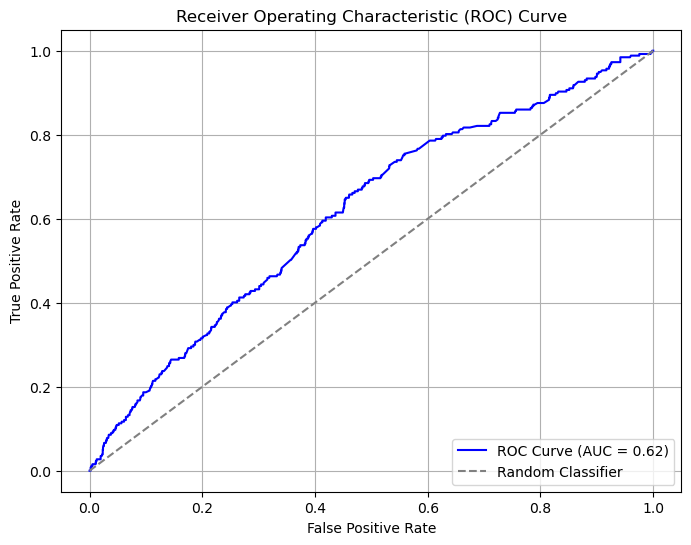

In [16]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_encoded, 
    Y_downsampled, 
    A_downsampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=A_downsampled
)

# =====================================================
# Train XGBoost Model
# =====================================================
from collections import Counter

# Calculate the scale_pos_weight
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]


model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    n_estimators=250,
    max_depth=4,          
    min_child_weight=5,   
    gamma=1,             
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
)
# model = XGBClassifier(
#     objective="binary:logistic",
#     learning_rate=0.01,
#     n_estimators=200,
#     max_depth=4,          
#     min_child_weight=3,   
#     gamma=1,             
#     eval_metric="aucpr",
#     scale_pos_weight=7.9,
# )



model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)])

### Evaluate on training data
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")
#  Evaluate on Test Data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<BarContainer object of 6 artists>

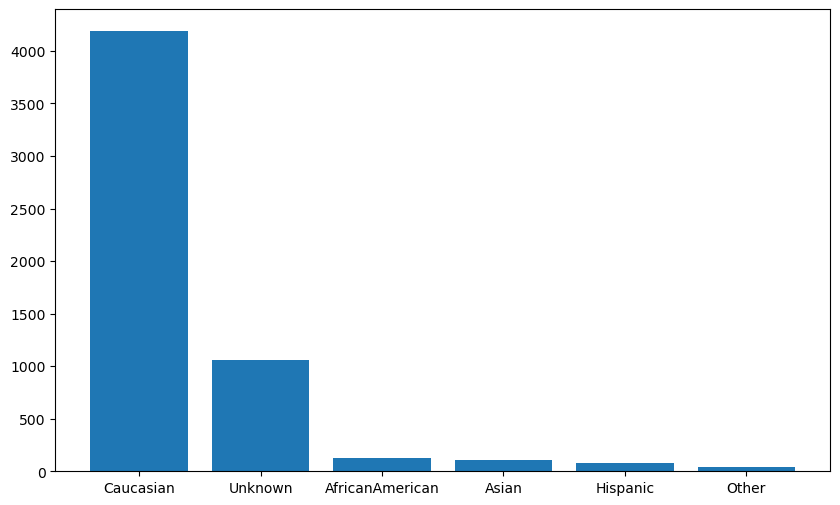

In [34]:
from matplotlib import pyplot as plt
### Distribution of sensitive attribute
plt.figure(figsize=(10, 6))
plt.bar(A_train.unique(), A_train.value_counts().values)

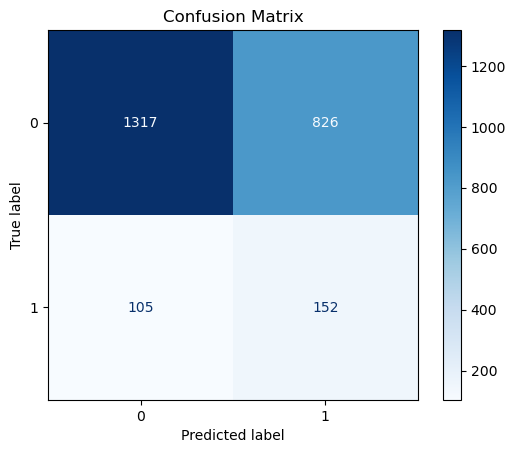

Accuracy: 0.61
Precision: 0.16
Recall: 0.59
F1 Score: 0.25


In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



In [36]:
def evaluate_fairness_one_vs_rest(
    model, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    A_test: pd.Series, 
    macro: bool = False
) -> pd.DataFrame:
    """
    Evaluate fairness metrics for a binary classifier on a one-vs-rest basis for each sensitive group.
    
    For each unique group in A_test, this function computes the metrics for that group versus all other groups.
    When `macro=True`, it computes metrics for the given group and then averages the metrics of the remaining groups;
    otherwise, it uses a binary sensitive feature (group vs. rest) with fairlearn's MetricFrame.
    
    Returns:
        pd.DataFrame: A dataframe with differences in metrics (both absolute and non-absolute) and the equalized odds difference.
    """
    y_pred = model.predict(X_test)
    unique_groups = A_test.unique()
    results = []
    
    df = pd.DataFrame({
        'sensitive_feature': A_test,
        'true_label': y_test,
        'predicted_label': y_pred
    })
    
    for group_val in unique_groups:
        if macro:
            # Calculate metrics for the current group
            df_group = df[df['sensitive_feature'] == group_val]
            group_size = len(df_group)
            tpr_group = true_positive_rate(df_group['true_label'], df_group['predicted_label'])
            fpr_group = false_positive_rate(df_group['true_label'], df_group['predicted_label'])
            prec_group = precision_score(df_group['true_label'], df_group['predicted_label'])
            rec_group = recall_score(df_group['true_label'], df_group['predicted_label'])
          
            
            # Calculate metrics for the rest groups and take the average
            df_rest = df[df['sensitive_feature'] != group_val]
            rest_metrics = df_rest.groupby('sensitive_feature').apply(
                lambda x: pd.Series({
                    'TPR': true_positive_rate(x['true_label'], x['predicted_label']),
                    'FPR': false_positive_rate(x['true_label'], x['predicted_label']),
                    'Precision': (
                        precision_score(x['true_label'], x['predicted_label'])
                        if len(x['true_label'].unique()) > 1 else 0.0
                    ),
                    'Recall': (
                        recall_score(x['true_label'], x['predicted_label'])
                        if len(x['true_label'].unique()) > 1 else 0.0
                    ),
                })
            )
            tpr_rest = rest_metrics['TPR'].mean() if not rest_metrics.empty else 0.0
            fpr_rest = rest_metrics['FPR'].mean() if not rest_metrics.empty else 0.0
            prec_rest = rest_metrics['Precision'].mean() if not rest_metrics.empty else 0.0
            rec_rest = rest_metrics['Recall'].mean() if not rest_metrics.empty else 0.0
            
        else:
            # Use MetricFrame with a binary sensitive feature (group vs. rest)
            A_binary = (A_test == group_val).astype(int)
            metrics_dict = {
                "TPR": true_positive_rate,
                "FPR": false_positive_rate,
                "Precision": precision_score,
                "Recall": recall_score,
            }
            mf = MetricFrame(
                metrics=metrics_dict,
                y_true=y_test,
                y_pred=y_pred,
                sensitive_features=A_binary
            )
            by_group = mf.by_group
            # Ensure both groups (1 for current, 0 for rest) are present
            if len(by_group) < 2:
                continue
            tpr_group, tpr_rest = by_group.loc[1, "TPR"], by_group.loc[0, "TPR"]
            fpr_group, fpr_rest = by_group.loc[1, "FPR"], by_group.loc[0, "FPR"]
            prec_group, prec_rest = by_group.loc[1, "Precision"], by_group.loc[0, "Precision"]
            rec_group, rec_rest = by_group.loc[1, "Recall"], by_group.loc[0, "Recall"]
            group_size = int(A_binary.sum())
        
        # Calculate metric differences
        tpr_diff = tpr_group - tpr_rest
        fpr_diff = fpr_group - fpr_rest
        prec_diff = prec_group - prec_rest
        rec_diff = rec_group - rec_rest
        
        results.append({
            "Group": group_val,
            "group_size": group_size,
            "accuracy": accuracy_score(df_group['true_label'], df_group['predicted_label']),    
            "TPR_diff_abs": abs(tpr_diff),
            "FPR_diff_abs": abs(fpr_diff),
            "Prec_diff_abs": abs(prec_diff),
            "Recall_diff_abs": abs(rec_diff),
            "TPR_diff_nonabs": tpr_diff,
            "FPR_diff_nonabs": fpr_diff,
            "Prec_diff_nonabs": prec_diff,
            "Recall_diff_nonabs": rec_diff,
            # Equalized odds difference is typically defined as the maximum of the absolute differences of TPR and FPR.
            "equalized_odds_difference": max(abs(tpr_diff), abs(fpr_diff)),
            ## Additional metrics are for lambda tuning
            "od": 0.5*(abs(tpr_diff) + abs(fpr_diff))
        })
    
    return pd.DataFrame(results)


In [37]:
evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test,macro=True)       

C:\Users\jx\AppData\Local\Temp\ipykernel_4860\2461984856.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_metrics = df_rest.groupby('sensitive_feature').apply(
C:\Users\jx\AppData\Local\Temp\ipykernel_4860\2461984856.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_metrics = df_rest.groupby('sensitive_feature').apply(
C:\Users\jx\AppData\Local\Temp\ipykernel_4860\2461984856.py:41: Deprecat

,Group,group_size,accuracy,TPR_diff_abs,FPR_diff_abs,Prec_diff_abs,Recall_diff_abs,TPR_diff_nonabs,FPR_diff_nonabs,Prec_diff_nonabs,Recall_diff_nonabs,equalized_odds_difference,od
0,Caucasian,1795,0.591086,0.312222,0.152846,0.044837,0.312222,0.312222,0.152846,0.044837,0.312222,0.312222,0.232534
1,AfricanAmerican,453,0.649007,0.272222,0.070935,0.046156,0.272222,0.272222,0.070935,0.046156,0.272222,0.272222,0.171579
2,Other,35,0.657143,0.378889,0.072963,0.201061,0.378889,0.378889,0.072963,0.201061,0.378889,0.378889,0.225926
3,Unknown,54,0.814815,0.421111,0.176124,0.141796,0.421111,-0.421111,-0.176124,-0.141796,-0.421111,0.421111,0.298617
4,Hispanic,48,0.770833,0.121111,0.122648,0.008462,0.121111,-0.121111,-0.122648,-0.008462,-0.121111,0.122648,0.121880
5,Asian,15,0.666667,0.421111,0.002027,0.141796,0.421111,-0.421111,0.002027,-0.141796,-0.421111,0.421111,0.211569


### Uncertainty
#accroding to the paper (Un)certainty of (Un)fairness: Preference-Based Selection of Certainly Fair Decision-Makers, it measures the favorable outcome for each group and the difference between the favorable outcomes of the groups, to determine the fairness certainties of the decision-makers of model, I am wondering what is the favorable outcome in our case? is it the correct prediction made(in other word accuracy)? Or among the people with true label ==1, how many of them are corretly predicted since we care more about the recall in this case?

In [38]:
import uncertainty


def uncertainty_one_vs_rest_recall(y_true, y_pred, A):
    results = {}
    groups = A.unique()
    for group in groups:
        i = A == group
        j = A != group
        # Calculate uncertainty for the current group vs. the rest， for now I do it for the recall, only count for "1" label
        results[group+"_vs_rest_uncertainty"] = uncertainty.uncertainty(i, j, y_pred, y_true)
    
    return pd.DataFrame(results, index=[0])

   


In [39]:

def uncertainty_one_vs_rest(y_true, y_pred, A):
    results = {}
    groups = A.unique()
    y_correct = y_true == y_pred
    E2 = [1]*len(y_true)
    for group in groups:
        i = A == group
        j = A != group
        # Calculate uncertainty for the current group vs. the rest, correct predictions for both '0' and '1' as the desired outputs
        results[group+"_vs_rest_uncertainty"] = uncertainty.uncertainty(i, j, y_correct, E2)
    
    return pd.DataFrame(results, index=[0])


In [40]:
uncertainty_one_vs_rest(y_test, y_pred, A_test)

e:\MIE\MIE8888\Fairlearn\Fairlearn\uncertainty.py:282: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  n_success_i = (E1 & i & E2).sum()
e:\MIE\MIE8888\Fairlearn\Fairlearn\uncertainty.py:284: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  beta_post_i = beta_prior + (i & E2).sum() - n_success_i
e:\MIE\MIE8888\Fairlearn\Fairlearn\uncertainty.py:287: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  n_success_j = (E1 & j & E2).sum()
e:\

,Caucasian_vs_rest_uncertainty,AfricanAmerican_vs_rest_uncertainty,Other_vs_rest_uncertainty,Unknown_vs_rest_uncertainty,Hispanic_vs_rest_uncertainty,Asian_vs_rest_uncertainty
0,0.004463,0.005604,0.05488,0.025837,0.033098,0.115082


In [41]:
uncertainty_one_vs_rest_recall(y_test, y_pred, A_test)

,Caucasian_vs_rest_uncertainty,AfricanAmerican_vs_rest_uncertainty,Other_vs_rest_uncertainty,Unknown_vs_rest_uncertainty,Hispanic_vs_rest_uncertainty,Asian_vs_rest_uncertainty
0,0.046855,0.055935,0.242953,0.248421,0.294179,0.508387


In [49]:
# =============================================================================
# Helper Functions for Fairness Calculation
# =============================================================================

def compute_group_metrics(y_true, y_pred):
    """Compute TPR, FPR, Precision, and Recall for a given group."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    FPR = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    recall = TPR  # Recall is the same as TPR
    
    return TPR, FPR, precision, recall


def fairness_at_different_split(labels, predictions, fairness_features):
    """
    Computes equalized odds differences for each fairness feature and split.
    For the 'gender_F' feature, only one split (0) is used;
    for other features, splits [1, 2, 3, 4] are used.

    labels: true labels -- Series
    predictions: predicted labels -- Series
    fairness_features: DataFrame with fairness features
    
    Returns a DataFrame with:
      - split_point
      - fairness_feature
      - equalized_odds_max: max(|TPR_diff|, |FPR_diff|)
      - equalized_odds: 0.5*(|TPR_diff| + |FPR_diff|)
    """
    results = []
    for fairness_feature in list(fairness_features.columns):
        
        splits = [0]
       
        for split in splits:
            # Create a binary split based on the fairness feature values
            fairness_binary = (fairness_features[fairness_feature] > split).astype(int)
            group0_idx = np.where(fairness_binary == 0)[0]
            group1_idx = np.where(fairness_binary == 1)[0]

            if len(group0_idx) == 0 or len(group1_idx) == 0:
                continue
                    
            group0_labels = np.array(labels)[group0_idx]
            group0_preds = np.array(predictions)[group0_idx]
    
            group1_labels = np.array(labels)[group1_idx]
            group1_preds = np.array(predictions)[group1_idx]

            TPR_0, FPR_0, _, _ = compute_group_metrics(group0_labels, group0_preds)
            TPR_1, FPR_1, _, _ = compute_group_metrics(group1_labels, group1_preds)

            tpr_diff = TPR_1 - TPR_0
            fpr_diff = FPR_1 - FPR_0

            results.append({
                'split_point': split,
                'fairness_feature': fairness_feature,
                'equalized_odds_max': max(abs(tpr_diff), abs(fpr_diff)),
                'equalized_odds': 0.5 * (abs(tpr_diff) + abs(fpr_diff))
            })
    return pd.DataFrame(results)

def compute_fairness_score(y_true, y_pred, fairness_features_df):
    """
    Computes the fairness score as the average over fairness features
    of the maximum equalized odds (0.5*(|TPR_diff|+|FPR_diff|)) 
    computed at different splits.
    y_true: true labels -- Series
    y_pred: predicted labels -- Series
    fairness_features_df: DataFrame with fairness features
    """
    result = fairness_at_different_split(y_true, y_pred, fairness_features_df)
    # For each fairness feature, get the maximum equalized odds value
    max_equalized_odds = result.groupby("fairness_feature")['equalized_odds'].max()
    # Average the maximum values across features
    average_max_equalized_odds = max_equalized_odds.mean()
    return average_max_equalized_odds



In [19]:
feature_names = X_train.columns
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

fairness_features_train = X_train_df[['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'race_Unknown']]
fairness_features_test = X_test_df[['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'race_Unknown']]

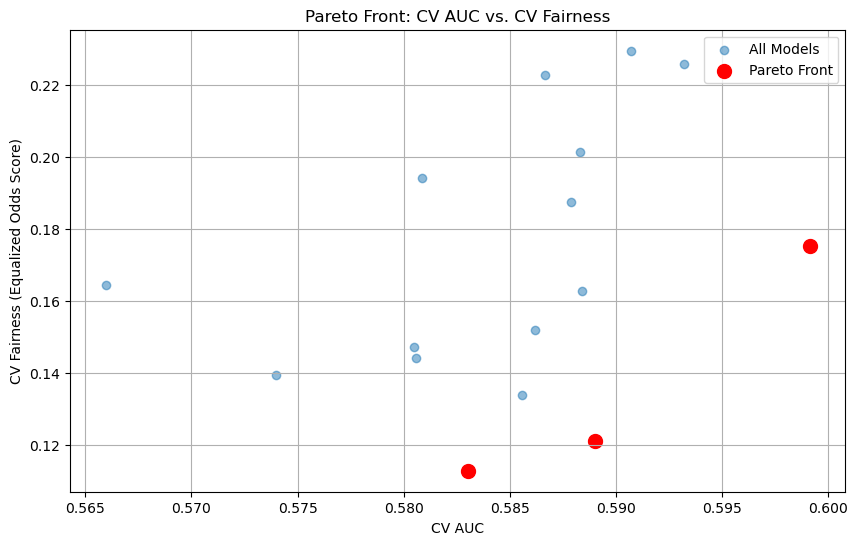


Pareto Front Results:


,params,train_auc,train_fairness,cv_auc,cv_fairness,test_auc,test_fairness
13,"{'alpha': 5.0, 'colsample_bytree': 0.7, 'learn...",0.164782,0.145630,0.599140,0.175302,0.627583,0.258683
14,"{'alpha': 5.0, 'colsample_bytree': 0.7, 'learn...",0.030570,0.033231,0.583026,0.112916,0.617283,0.120116
15,"{'alpha': 5.0, 'colsample_bytree': 0.7, 'learn...",0.035348,0.036420,0.588986,0.121223,0.608836,0.098680


In [54]:
# =============================================================================
# 1. Define Parameter Grid for XGBoost
# =============================================================================

grid_search_results_path = "./experiment_result/grid_search_results.csv"
pareto_frontier_param_path = "./experiment_result/pareto_frontier_param.json"

# Initialize the CSV file for results
if not os.path.exists(grid_search_results_path):
    with open(grid_search_results_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['params', 'cv_auc', 'cv_fairness', 'test_auc', 'test_fairness'])
        writer.writeheader()

param_grid = {
    'n_estimators': [200],  # Number of boosting rounds
    'learning_rate': [0.1],  # Step size shrinkage
    'max_depth': [3, 5],  # Maximum depth of a tree
    'subsample': [1.0, 0.7],  # Subsample ratio of the training instances
    'colsample_bytree': [1.0, 0.7],  # Subsample ratio of columns
    'alpha': [1.0, 5.0],
    'reg_lambda': [2.0],
    'scale_pos_weight': [10.0]
}

# =============================================================================
# 2. Grid Search with 3-Fold CV (Optimizing AUC and Fairness)
# =============================================================================

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []
grid = list(ParameterGrid(param_grid))

for params in grid:
    # Lists to store fold-level metrics
    fold_cv_auc = []
    fold_cv_fair = []
    fold_train_auc = []
    fold_train_fair = []
    
    for train_idx, val_idx in cv.split(X_train_df, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        fairness_tr = fairness_features_train.iloc[train_idx]
        fairness_val = fairness_features_train.iloc[val_idx]
        
        # Initialize and train model using current parameter set
        model = xgb.XGBClassifier(
            **params,
            eval_metric='logloss'
        )
        model.fit(X_tr, y_tr)
        #For training set
        y_tr_pred = model.predict(X_tr)
        y_tr_pred_prob = model.predict_proba(X_tr)[:, 1]
        # Compute AUC on training set
        auc_tr = roc_auc_score(y_tr, y_tr_pred_prob)
        # Compute Fairness Score(avg of max eod of all features)
        fair_tr = compute_fairness_score(y_tr, y_tr_pred, fairness_tr)
        
        fold_train_auc.append(auc_tr)
        fold_train_fair.append(fair_tr)

        # For CV, get predictions and probabilities on validation set
        y_val_pred = model.predict(X_val)
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        # Compute AUC on validation set
        auc_val = roc_auc_score(y_val, y_val_pred_prob)
        # Compute Fairness Score(avg of max eod of all features)
        fair_val = compute_fairness_score(y_val, y_val_pred, fairness_val)
        
        fold_cv_auc.append(auc_val)
        fold_cv_fair.append(fair_val)
    
    # Average metrics across CV and train folds
    avg_train_auc = np.mean(fold_train_auc)
    avg_train_fair = np.mean(fold_train_fair)
    avg_cv_auc = np.mean(fold_cv_auc)
    avg_cv_fair = np.mean(fold_cv_fair)
    
    # Retrain the model on the full training set with the given parameters
    final_model = xgb.XGBClassifier(
        **params,
        eval_metric='logloss'
    )
    final_model.fit(X_train, y_train)
    y_test_pred = final_model.predict(X_test)
    y_test_pred_prob = final_model.predict_proba(X_test)[:, 1]
    
    # Compute test metrics
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    test_fair = compute_fairness_score(y_test, y_test_pred, fairness_features_test)
    
    # Save all metrics along with the parameter settings
    record = {
        'params': params,
        'train_auc': avg_train_fair,
        'train_fairness': fair_tr,
        'cv_auc': avg_cv_auc,
        'cv_fairness': avg_cv_fair,
        'test_auc': test_auc,
        'test_fairness': test_fair
    }

    # Append the record to the results CSV
    with open(grid_search_results_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=record.keys())
        writer.writerow(record)
    results.append(record)

results_df = pd.DataFrame(results)

# =============================================================================
# 3. Compute the Pareto Front Based on CV Metrics
# =============================================================================
# want to maximize CV AUC and minimize CV fairness.
# To turn the maximization of AUC into minimization, we use -cv_auc.
# Each point's "cost" vector is: [ -cv_auc, cv_fairness ]
costs = np.column_stack([-results_df['cv_auc'].values, results_df['cv_fairness'].values])

def pareto_frontier(costs):
    num_points = costs.shape[0]
    is_pareto = np.ones(num_points, dtype=bool)
    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                # If solution j is as good in every objective and strictly better in at least one, i is dominated.
                if (costs[j, 0] <= costs[i, 0] and costs[j, 1] <= costs[i, 1]) and \
                   (costs[j, 0] < costs[i, 0] or costs[j, 1] < costs[i, 1]):
                    is_pareto[i] = False
                    break
    return is_pareto

pareto_mask = pareto_frontier(costs)
pareto_df = results_df[pareto_mask]

## Saving pareto_params
pareto_params = [r['params'] for r in pareto_df.to_dict('records')]
with open(pareto_frontier_param_path, 'w') as f:
    json.dump(pareto_params, f, indent=4)

# =============================================================================
# 4. Plot the Pareto Front
# =============================================================================
plt.figure(figsize=(10,6))
plt.scatter(results_df['cv_auc'], results_df['cv_fairness'], label="All Models", alpha=0.5)
plt.scatter(pareto_df['cv_auc'], pareto_df['cv_fairness'], color="red", label="Pareto Front", s=100)
plt.xlabel("CV AUC")
plt.ylabel("CV Fairness (Equalized Odds Score)")
plt.title("Pareto Front: CV AUC vs. CV Fairness")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# 5. Report the Results
# =============================================================================

print("\nPareto Front Results:")
pareto_df


## fairUS

In [85]:
def fairness_at_split(labels, prediction_prob, threshold, fairness_features_df, splits):
    '''
    fairness_features_df: Dataframe
    splits: list contains split point for each feature in fairness_features_df
    '''
    results = []
    predictions = (prediction_prob >= threshold).astype(int)
    roc_auc = roc_auc_score(labels, prediction_prob)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    for fairness_feature, split in zip(fairness_features_df.columns, splits):
        fairness_binary = (fairness_features_df[fairness_feature] > split)
        group0_idx = np.where(fairness_binary == 0)[0]
        group1_idx = np.where(fairness_binary == 1)[0]

        if len(group0_idx) == 0 or len(group1_idx) == 0:
            continue
        
        group0_labels = np.array(labels)[group0_idx]
        group0_preds = np.array(predictions)[group0_idx]

        group1_labels = np.array(labels)[group1_idx]
        group1_preds = np.array(predictions)[group1_idx]

        TPR_0, FPR_0, _, _ = compute_group_metrics(group0_labels, group0_preds)
        TPR_1, FPR_1, _, _ = compute_group_metrics(group1_labels, group1_preds)

        tpr_diff = TPR_1 - TPR_0
        fpr_diff = FPR_1 - FPR_0

        results.append({
            'split_point': split,
            'fairness_feature': fairness_feature,
            'accuracy': acc,
            'f1': f1,
            'roc_auc': roc_auc,
            'equalized_odds_max': max(abs(tpr_diff), abs(fpr_diff)),
            'equalized_odds': 0.5 * (abs(tpr_diff) + abs(fpr_diff))
        })
    return pd.DataFrame(results)



def compute_group_metrics(y_true, y_pred):
    """Compute TPR, FPR, Precision, and Recall for a given group."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    FPR = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    recall = TPR  # Recall is the same as TPR
    
    return TPR, FPR, precision, recall



In [86]:
X = X_train_df.copy()
y = y_train.copy()
PRIV_FEATURE = "race_Asian"
fairness_features_df = fairness_features_train[[PRIV_FEATURE]]
THRESHOLD = 0.5
SPLITS_OF_FEATURES = [0]

In [87]:
with open('./experiment_result/pareto_frontier_param.json', 'r') as file:
    data = json.load(file)


# selecting the first param
param = next(item for item in data if isinstance(item, dict))

print("used param：")
for key, value in param.items():
    print(f"{key}: {value}")


best_model = xgb.XGBClassifier(**param)
best_model.fit(X_train, y_train)
prediction_prob_train = best_model.predict_proba(X_train)[:, 1]
prediction_prob_test = best_model.predict_proba(X_test)[:, 1]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
orig_train_auc = []
orig_train_fair = []
orig_cv_auc = []
orig_cv_fair = []
for train_idx, val_idx in cv.split(X, y):
        X_train_fold, y_train_fold = X.iloc[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y[val_idx]
        fairness_features_df_train_fold = fairness_features_df.iloc[train_idx]
        fairness_features_df_val_fold = fairness_features_df.iloc[val_idx]


    
        clf = xgb.XGBClassifier(**param)
        clf.fit(X_train_fold, y_train_fold)
        # -----------------
        # Compute training metrics
        y_pred_proba_train = clf.predict_proba(X_train_fold)[:, 1]
        metrics_train = fairness_at_split(y_train_fold, y_pred_proba_train, THRESHOLD, fairness_features_df_train_fold, SPLITS_OF_FEATURES)### Train statistic should be calculated on orig or sampled data
        metrics_train.set_index("fairness_feature", inplace=True)
        # For example, take the metric for a specific fairness feature (e.g., 'gender_F')
        eod_train = metrics_train.loc[PRIV_FEATURE, "equalized_odds"]
        auc_train = metrics_train.loc[PRIV_FEATURE, "roc_auc"]
        orig_train_fair.append(eod_train)
        orig_train_auc.append(auc_train)

        # -----------------
        # Compute CV metrics
        y_pred_proba_val = clf.predict_proba(X_val_fold)[:, 1]
        metrics_val = fairness_at_split(y_val_fold, y_pred_proba_val, THRESHOLD, fairness_features_df_val_fold, SPLITS_OF_FEATURES)
        metrics_val.set_index("fairness_feature", inplace=True)
       
        # For example, take the metric for a specific fairness
        eod_val = metrics_val.loc[PRIV_FEATURE, "equalized_odds"]
        auc_val = metrics_val.loc[PRIV_FEATURE, "roc_auc"]
        orig_cv_fair.append(eod_val)
        orig_cv_auc.append(auc_val)

print("Without Unsampling:")
print("Train AUC: ", np.nanmean(orig_train_auc))
print("Train Fairness: ", np.nanmean(orig_train_fair))
print("CV AUC: ", np.nanmean(orig_cv_auc))
print("CV Fairness: ", np.nanmean(orig_cv_fair))

used param：
alpha: 5.0
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 3
n_estimators: 200
reg_lambda: 2.0
scale_pos_weight: 10.0
subsample: 0.7
Without Unsampling:
Train AUC:  0.7894604084101567
Train Fairness:  0.17930386003258433
CV AUC:  0.592788539247194
CV Fairness:  0.09972578338659338


In [62]:
metrics_val

,split_point,accuracy,f1,roc_auc,equalized_odds_max,equalized_odds
fairness_feature,,,,,,
race_Asian,0,0.57579,0.201613,0.563899,NaN,NaN


In [56]:
orig_cv_fair

[0.11547307608458685, nan, 0.08397849068859992]

In [ ]:
orig_dataset = X_encoded.copy()
orig_dataset["target"] = Y_downsampled
orig_group = A_downsampled
TARGET_COL = 'target'
PRIV_FEATURE = 'race_Asian'
PRIV_VALUE_FEATURE = 0
UNPRIV_VALUE_FEATURE = 1
PRIV_CLASS = 0  ## there doesn't seem to be a priviledged target in the data
CATEGORICAL = encoded_col_names
orig_dataset[TARGET_COL] = orig_dataset[TARGET_COL].astype(int)


### CTGAN On Priv Target Group

In [ ]:
unprivileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
privileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
print(unprivileged_data_priv_target.shape[0])
print(privileged_data_priv_target.shape[0])

46
7130


In [ ]:
from ctgan import CTGAN
if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)
else:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(privileged_data_priv_target , CATEGORICAL, epochs = 200)


# from ctgan import CTGAN

# if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
#     ctgan_priv_target = CTGAN(verbose=True)
#     # Fit the synthesizer to the unprivileged features
#     ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\jx\anaconda3\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (0.78) | Discrim. (0.27): 100%|██████████| 200/200 [00:33<00:00,  6.03it/s] 


### CTGAN On Unpriv Target Group

In [ ]:
unprivileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
privileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]

print(unprivileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0]-unprivileged_data_unpriv_target.shape[0])

5
819
814


In [60]:
from ctgan import CTGAN
if unprivileged_data_unpriv_target.shape[0] <= privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(unprivileged_data_unpriv_target , CATEGORICAL, epochs = 200)

if unprivileged_data_unpriv_target.shape[0] > privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(privileged_data_unpriv_target , CATEGORICAL, epochs = 200)


Gen. (-0.15) | Discrim. (-0.14):  79%|███████▉  | 158/200 [00:34<00:09,  4.62it/s]


KeyboardInterrupt: 

In [ ]:
# !pip install optuna
# !pip install cmaes

In [ ]:
import optuna
import math
import time
feature_columns = list(orig_dataset.columns)
feature_columns.remove('target')

In [ ]:
def Upsampling_Dataset(lambda_0, lambda_1):
    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    #print(priv_target_samples)
    # print('number of samples i added(lambda_0)', len(priv_target_samples))
    
    unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(lambda_1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    # print('number of samples i added(lambda_1)', len(unpriv_target_samples))
   
    if len((priv_target_samples)>0) and (len(unpriv_target_samples)==0):
        df_list = [orig_dataset, priv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(unpriv_target_samples)>0) and (len(priv_target_samples)==0):
        df_list = [orig_dataset, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_debias = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)>0) and (len(unpriv_target_samples)>0):
        df_list = [orig_dataset, priv_target_samples, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)==0) and (len(unpriv_target_samples)==0):
        upsampled_df = orig_dataset
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    return upsampled_df


In [ ]:
priv_target_samples = ctgan_priv_target.sample(math.floor(0.1 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    
unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(0.1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    

In [ ]:
all_upsampled_acc = []
all_upsampled_op_diff = []

def FairUS_Finding_Optimal_Lambdas_Optuna(trial):

    # Initialize original Equalized odds and Accuracy Scores
    clf1 = model #### Original model trained on original dataset
    metrics = evaluate_fairness_one_vs_rest(clf1, orig_dataset[feature_columns], orig_dataset[TARGET_COL], orig_group)
    metrics.set_index("Group", inplace=True)  # Set 'group' as the index
    orig_od_diff = metrics.loc["Asian", "od"]  # Access 'od' for 'Asian'
    orig_acc = accuracy_score(orig_dataset[TARGET_COL], model.predict(orig_dataset[feature_columns]))

    OrigFair_score = orig_od_diff
    OrigAcc_score = orig_acc

    # Initialize matrices to store Fairness and Accuracy results
    #Fairness_Matrix = np.zeros((num_steps, num_steps))
    #Accuracy_Matrix = np.zeros((num_steps, num_steps))
    

    lambda_0 =  trial.suggest_float("lambda_0", 0, 2)
    lambda_1 =  trial.suggest_float("lambda_1", 0, 2)

    upsampled_df = Upsampling_Dataset(lambda_0, lambda_1)
    y_debias = upsampled_df[TARGET_COL]
    upsampled_df_features = upsampled_df.loc[:, feature_columns]
    upsampled_group = upsampled_df_features[['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other']].idxmax(axis=1).str.replace('race_', '')

  ###########################################################################################################
  # Train XGBoost Model on upsampled dataset
  ###########################################################################################################
    clf2 = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    n_estimators=250,
    max_depth=4,          
    min_child_weight=5,   
    gamma=1,             
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    )
    clf2.fit(upsampled_df_features, y_debias)



    upsampled_metrics = evaluate_fairness_one_vs_rest(clf2, upsampled_df_features, y_debias, upsampled_group)
    upsampled_metrics.set_index("Group", inplace=True)
    upsampled_od_diff = upsampled_metrics.loc["Asian", "od"] ## Selecting the od of Asian group
    upsampled_acc = accuracy_score(y_debias, model.predict(upsampled_df_features))
    CurrFair_score = upsampled_od_diff
    CurrAcc_score = upsampled_acc
    # if ALPHA == 1:
    #   optimization_objective = CurrFair_score/mean(orig_od_diff)
    # else:
      # optimization_objective = (ALPHA*CurrFair_score/mean(orig_od_diff)) - ((1-ALPHA)*CurrAcc_score/mean(orig_acc))
    #optimization_objective = (CurrFair_score/mean(orig_od_diff)) - (CurrAcc_score/mean(orig_acc))
    optimization_objective = (CurrFair_score/OrigFair_score) - (CurrAcc_score/OrigAcc_score)
    # optimization_objective = (CurrFair_score) - (CurrAcc_score)

    # Update fairness matrix with Equalized odds subtraction
    #Fairness_Matrix[i, j] = -(CurrFair_score - OrigFair_score)
    # Update accuracy matrix with Minos accuracy subtraction
    #Accuracy_Matrix[i, j] = (CurrAcc_score - OrigAcc_score)


    #fairness_delta = np.max(Fairness_Matrix)-np.min(Fairness_Matrix)
    #acc_delta = np.max(Accuracy_Matrix)-np.min(Accuracy_Matrix)
    #fairness_factor = acc_delta / fairness_delta
    #scaled_fairness_matrix = fairness_factor * Fairness_Matrix


    #Accuracy_Matrix = -(Accuracy_Matrix)
    #scaled_fairness_matrix= -(scaled_fairness_matrix)
    print ('lambda_0:',lambda_0)
    print ('lambda_1:',lambda_1)
    #print ('fairness matrix before scaling: ',Fairness_Matrix)
    #print ('fairness matrix after scaling: ',scaled_fairness_matrix)
    #print ('acc matrix is: ', Accuracy_Matrix)

    # Save upsampled_acc and upsampled_od_diff as trial attributes
    # upsampled_acc = mean(upsampled_acc)
    # upsampled_od_diff = mean(upsampled_od_diff)
    trial.set_user_attr('upsampled_acc', upsampled_acc)
    trial.set_user_attr('upsampled_op_diff', upsampled_od_diff)
    print('---------------------------------------trail upsampled_acc is : ', trial.user_attrs.get('upsampled_acc'))
    print('---------------------------------------trail upsampled_op_diff is : ', trial.user_attrs.get('upsampled_op_diff'))
    all_upsampled_acc.append(upsampled_acc)
    all_upsampled_op_diff.append(upsampled_od_diff)

    # Return optimal dataset upsampled with lambda_0, lambda_1 values
    # return optimization_objective #scaled_fairness_matrix
    return CurrFair_score, CurrAcc_score #for multi objective


In [ ]:
start_time = time.time()

In [ ]:
CME_flag = False

if CME_flag:
  from optuna.samplers import CmaEsSampler

  # Create an instance of CmaEsSampler
  # Create an instance of CmaEsSampler with specified parameters
  cma_es_sampler = CmaEsSampler(
      sigma0=0.01,  # Initial standard deviation of the distribution.
      n_startup_trials=10,  # The number of trials before using CMA-ES.
      independent_sampler=optuna.samplers.RandomSampler(seed=0)  # Sampler used for the first `n_startup_trials`.
  )


  # Pass the instance of CmaEsSampler to create_study
  # study = optuna.create_study(sampler=cma_es_sampler, direction='minimize')
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=400)
else:
  from optuna.samplers import TPESampler

  # Create an instance of TPESampler with custom parameters
  # You can adjust parameters like n_startup_trials, n_ei_candidates, etc.
  tpe_sampler = TPESampler(n_startup_trials=20, n_ei_candidates=24, multivariate=True)

  # Pass the instance of TPESampler to create_study
  # study = optuna.create_study(sampler=tpe_sampler, direction='minimize') #directions=['minimize', 'maximize']
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=10)

c:\Users\jx\anaconda3\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-03-12 13:36:30,752] A new study created in memory with name: no-name-ebd8fd9e-5058-4d14-b02a-f25e3d1c54a8
[W 2025-03-12 13:36:31,053] Trial 0 failed with parameters: {} because of the following error: UnboundLocalError("cannot access local variable 'df_group' where it is not associated with a value").
Traceback (most recent call last):
  File "c:\Users\jx\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\jx\AppData\Local\Temp\ipykernel_4860\399271322.py", line 8, in FairUS_Finding_Optimal_Lambdas_Optuna
    metrics = evaluate_fairness_one_vs_rest(clf1, orig_dataset[feature_columns], orig_dataset[TARGET_COL], orig_group)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

UnboundLocalError: cannot access local variable 'df_group' where it is not associated with a value

In [ ]:
end_time = time.time()
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

pareto_front_trials = study.best_trials
pareto_front_trials = sorted(pareto_front_trials, key=lambda trial: trial.values[0])


trail_list = []
fairness_values_list = []

acc_values_list = []
growth_list = []

# Process each trial in the Pareto front
for trial in pareto_front_trials:
   trail_list.append(trial.number)
   fairness_values_list.append(trial.values[0])
   acc_values_list.append(trial.values[1])

   lambda1 = trial.params['lambda_0']
   lambda2 = trial.params['lambda_1']
   upsampled_df = Upsampling_Dataset(lambda1,lambda2)
   growth_list.append((len(upsampled_df) - len(orig_dataset))/ len(orig_dataset) * 100 )

   print("Trial Number:", trial.number)
   print("Values (Objectives):", trial.values)
   print("Parameters:", trial.params)
   print("Dataset Growth Percent :", (len(upsampled_df) - len(orig_dataset))/ len(orig_dataset) * 100)
   print('---------------------------------------------------------------------------------------------------')
   y_debias = upsampled_df[TARGET_COL]
   upsampled_df_features = upsampled_df.loc[:, feature_columns]

   print("End Of Trial Number:", trial.number)
   print('---------------------------------------------------------------------------------------------------')



Trial Number: 0
Values (Objectives): [0.30049559052096175, 0.7203802733214498]
Parameters: {'lambda_0': 1.2371695413341257, 'lambda_1': 0.08202145393430715}
Dataset Growth Percent : 110.375
---------------------------------------------------------------------------------------------------
End Of Trial Number: 0
---------------------------------------------------------------------------------------------------
Trial Number: 3
Values (Objectives): [0.3335638623973052, 0.7408396588885765]
Parameters: {'lambda_0': 1.844620210953995, 'lambda_1': 0.3380692358535009}
Dataset Growth Percent : 166.775
---------------------------------------------------------------------------------------------------
End Of Trial Number: 3
---------------------------------------------------------------------------------------------------
Trial Number: 8
Values (Objectives): [0.3406519175184003, 0.7413957717663106]
Parameters: {'lambda_0': 1.902552901381397, 'lambda_1': 0.63693493708548}
Dataset Growth Percent : 

In [ ]:
TARGET_COL = 'target'
PRIV_FEATURE = 'gender_F' #repalce with other fair features
fairness_features = A_train[[PRIV_FEATURE]]
split = 0
PRIV_VALUE_FEATURE = [1]
UNPRIV_VALUE_FEATURE = [0]
PRIV_CLASS = 1  ## There doesn't seem to be a priviledged target in the data
CATEGORICAL = likely_categorical


def Upsampling_Dataset(X, y, lambda_0, lambda_1):
    orig_dataset =X.copy()
    orig_dataset["target"] = y
    TARGET_COL = 'target'
    ### CTGAN On Priv Target Group
    unprivileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE].isin(UNPRIV_VALUE_FEATURE)) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
    privileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE].isin(PRIV_VALUE_FEATURE)) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))

    if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
        ctgan_priv_target = CTGAN(verbose=True)
        # Fit the synthesizer to the unprivileged features
        ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)
    else:
        ctgan_priv_target = CTGAN(verbose=True)
        # Fit the synthesizer to the unprivileged features
        ctgan_priv_target.fit(privileged_data_priv_target , CATEGORICAL, epochs = 200)
    ########################################
    
    ### CTGAN On Unpriv Target Group
    unprivileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE].isin(UNPRIV_VALUE_FEATURE)) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
    privileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE].isin(PRIV_VALUE_FEATURE)) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
    
    if unprivileged_data_unpriv_target.shape[0] <= privileged_data_unpriv_target.shape[0]:
        ctgan_unpriv_target = CTGAN(verbose=True)
        # Fit the synthesizer to the unprivileged features
        ctgan_unpriv_target.fit(unprivileged_data_unpriv_target , CATEGORICAL, epochs = 200)

    else:
        ctgan_unpriv_target = CTGAN(verbose=True)
        # Fit the synthesizer to the unprivileged features
        ctgan_unpriv_target.fit(privileged_data_unpriv_target , CATEGORICAL, epochs = 200)
    ########################################



    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    #print(priv_target_samples)
    # print('number of samples i added(lambda_0)', len(priv_target_samples))
    
    unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(lambda_1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    # print('number of samples i added(lambda_1)', len(unpriv_target_samples))
   
    if len((priv_target_samples)>0) and (len(unpriv_target_samples)==0):
        df_list = [orig_dataset, priv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
      
    if (len(unpriv_target_samples)>0) and (len(priv_target_samples)==0):
        df_list = [orig_dataset, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
       
    if (len(priv_target_samples)>0) and (len(unpriv_target_samples)>0):
        df_list = [orig_dataset, priv_target_samples, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        
    if (len(priv_target_samples)==0) and (len(unpriv_target_samples)==0):
        upsampled_df = orig_dataset

    return upsampled_df


In [ ]:
def fairness_at_split(labels, prediction_prob, threshold, fairness_features,splits):
    results = []
    predictions = (prediction_prob >= threshold).astype(int)
    roc_auc = roc_auc_score(labels, prediction_prob)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    for fairness_feature, split in zip(fairness_features.columns, splits):
        fairness_binary = (fairness_features[fairness_feature] > split)
        group0_idx = np.where(fairness_binary == 0)[0]
        group1_idx = np.where(fairness_binary == 1)[0]

        if len(group0_idx) == 0 or len(group1_idx) == 0:
            continue
        
        group0_labels = np.array(labels)[group0_idx]
        group0_preds = np.array(predictions)[group0_idx]

        group1_labels = np.array(labels)[group1_idx]
        group1_preds = np.array(predictions)[group1_idx]

        TPR_0, FPR_0, _, _ = compute_group_metrics(group0_labels, group0_preds)
        TPR_1, FPR_1, _, _ = compute_group_metrics(group1_labels, group1_preds)


        results.append({
            'split_point': split,
            'fairness_feature': fairness_feature,
            'accuracy': acc,
            'f1': f1,
            'roc_auc': roc_auc,
            'equalized_odds_max': max(abs(tpr_diff), abs(fpr_diff)),
            'equalized_odds': 0.5 * (abs(tpr_diff) + abs(fpr_diff))
        })
    return pd.DataFrame(results)


def FairUS_Finding_Optimal_Lambdas_Optuna(trial):
    
    lambda_0 = trial.suggest_float("lambda_0", 0, 2)
    lambda_1 = trial.suggest_float("lambda_1", 0, 2)
    
    cv = StratifiedKFold(n_splits=3)
    cv_fairness_cv = []
    cv_accuracy_cv = []
    cv_fairness_train = []
    cv_accuracy_train = []

    # Loop over each fold
    for train_idx, val_idx in cv.split(X, y):
        # Use different names for the fold splits to avoid confusion with any global variables
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        # Upsample training data with current lambdas
        upsampled_train = Upsampling_Dataset(X_train_fold, y_train_fold, lambda_0, lambda_1)
        y_debias = upsampled_train[TARGET_COL]
        X_debias = upsampled_train[feature_columns]

        # Train model on the debiased training data
        clf = XGBClassifier(**param)
        clf.fit(X_debias, y_debias)
        
        # -----------------
        # Compute training metrics
        y_pred_proba_train = clf.predict_proba(X_train_fold)
        metrics_train = fairness_at_split(y_train_fold, y_pred_proba_train, threshold, fairness_features, splits)
        metrics_train.set_index("fairness_feature", inplace=True)
        # For example, take the metric for a specific fairness feature (e.g., 'gender_F')
        eod_train = metrics_train.loc["gender_F", "equalized_odds"]
        auc_train = metrics_train.loc["gender_F", "roc_auc"]
        cv_fairness_train.append(eod_train)
        cv_accuracy_train.append(auc_train)

        # -----------------
        # Compute cross-validation (CV) metrics on validation set
        y_pred_proba_val = clf.predict_proba(X_val_fold)
        metrics_cv = fairness_at_split(y_val_fold, y_pred_proba_val, threshold, fairness_features, splits)
        metrics_cv.set_index("fairness_feature", inplace=True)
        eod_cv = metrics_cv.loc["gender_F", "equalized_odds"]
        auc_cv = metrics_cv.loc["gender_F", "roc_auc"]
        cv_fairness_cv.append(eod_cv)
        cv_accuracy_cv.append(auc_cv)

    # Average metrics across folds
    avg_eod_cv = np.mean(cv_fairness_cv)
    avg_auc_cv = np.mean(cv_accuracy_cv)
    avg_eod_train = np.mean(cv_fairness_train)
    avg_auc_train = np.mean(cv_accuracy_train)

    # Save metrics for further analysis
    trial.set_user_attr('avg_eod_cv', avg_eod_cv)
    trial.set_user_attr('avg_auc_cv', avg_auc_cv)
    trial.set_user_attr('avg_eod_train', avg_eod_train)
    trial.set_user_attr('avg_auc_train', avg_auc_train)

    # Return objectives (here we aim to minimize EOD difference and maximize AUC)
    # Since Optuna minimizes by default, we can return -avg_auc_cv to maximize AUC.
    return avg_eod_cv, -avg_auc_cv

In [24]:
import numpy as np
data = np.array([[1, 2], [3, 4], [5, 6]])  # Shape: (3, 2)
centroids = np.array([[1, 1], [4, 5]])  #shape: (2,2)

In [25]:
distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)  # Compute distances
labels = np.argmin(distances, axis=1)


In [28]:
distances.shape
labels.shape

(3,)

In [36]:
def max_ones_after_flip(s):
    initial_ones = s.count('1')
    max_diff = current_diff = 0
    for c in s:
        d = 1 if c == '0' else -1
        current_diff = max(d, current_diff + d)
        max_diff = max(max_diff, current_diff)
    return initial_ones + max_diff

# 示例
s = "101001001"
print(max_ones_after_flip(s))  # 输出: 4

7


In [38]:
(2/5 + 1 + 4/7)/3

0.6571428571428571